In [1]:
import pickle
import gzip

import torch
from torch import nn
from torch import optim
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
from matplotlib import pyplot as plt

from utils import SeqDataloader, OneDiffDataLoader, ProfileDB


In [2]:
class torch_gru(nn.Module):
    def __init__(self, h_w, x_w, y_w, **kwargs):
        super().__init__()
        self.hidden_width = h_w
        self.input_width = x_w
        self.output_width = y_w

        self.gru = nn.GRU(x_w, h_w, batch_first=True)
        self.fc = nn.Linear(h_w, y_w)
    
    def forward(self, x, h_0):
        """
        params
        @x: [batchsize, sequencesize, inputwidth]
        @h_0: [batchsize, hiddenwidth]

        return
            output: [batchsize, outputwidth]
            h_t: [batchsize, hiddenwidth]
        """
        h_0 = h_0.view(1, *h_0.shape)
        output, h_t = self.gru(x, h_0)
        output = self.fc(torch.tanh(output[:, -1]))
        return torch.log_softmax(output, dim=1), h_t[0]

    def single_forward(self, x, h):
        x = x.view(x.shape[0], 1, *x.shape[1:])
        return self.forward(x, h)

In [3]:
device = torch.device(2) # torch.device(0) 为使用第一张GPU，torch.device('cpu')为不使用GPU

input_size = 5
profile_size = 15
output_size = 2


batch = 512
sequence = 32
epochs = 16

criterion_initializer = nn.NLLLoss
criterion_parameters = {}
optimizer_initializer = optim.Adam
optimizer_parameters = {'lr': 1e-2, 'weight_decay': 1e-5}
scheduler_initializer = optim.lr_scheduler.StepLR
scheduler_parameters = {'step_size': 20, 'gamma': 0.2}

nf32 = np.float32
tf32 = torch.float32

In [4]:
data = pickle.load(gzip.open('dae-data-5dim.gzip','rb'))
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

In [5]:
gru = torch_gru(profile_size, input_size, output_size)
gru.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(gru.parameters(), lr=1e-2, weight_decay=1e-5)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.7)

profiledb = ProfileDB()
default_profile = np.zeros(profile_size, dtype=nf32)

In [6]:
def train_a_epoch(gru, dl: SeqDataloader):
    total_loss = 0
    total_right = 0
    total_wrong = 0
    cnt = 0
    for x, index, x_ in dl:
        x = torch.from_numpy(x).to(device)
        x_ = torch.from_numpy(x_).to(device)

        profiles = profiledb.getProfiles(index, default=default_profile)
        profiles = torch.from_numpy(np.array(profiles, dtype=nf32)).to(device)

        optimizer.zero_grad()

        y, ret_profiles = gru(x, profiles)
        loss = criterion(y, torch.zeros(
            y.shape[0], dtype=torch.int64, device=device))
        loss.backward()
        total_loss += loss.item() * y.shape[0]

        x[:, -1] = x_
        y_, _ = gru(x, profiles)
        loss = criterion(y_, torch.ones(
            y.shape[0], dtype=torch.int64, device=device))
        loss.backward()

        optimizer.step()

        total_right += y.argmax(1).sum().item()
        total_wrong += y_.argmax(1).sum().item()
        total_loss += loss.item() * y.shape[0]

        cnt += y.shape[0]

        profiledb.setProfiles(index, ret_profiles.detach().cpu().numpy())
    return total_loss/cnt, total_right/cnt, total_wrong/cnt

In [7]:
@torch.no_grad()
def judge(x: np.ndarray, indexes: np.ndarray, index: str):
    normal = indexes == index
    dl = OneDiffDataLoader(
        x, normal, one_diff_index=True, batch=batch, shuffle=False)

    gru.eval()

    result = []

    for x, batch_normal in dl:
        x = torch.from_numpy(x).to(device)

        profiles = profiledb.getProfiles(
            [index], default=default_profile) * x.shape[0]
        profiles = torch.from_numpy(np.array(profiles, dtype=nf32)).to(device)

        y, ret_profiles = gru.single_forward(x, profiles)
        result.append(y.argmax(1))

        ret_profiles = ret_profiles[batch_normal]
        profiledb.setProfiles(
            [index] * ret_profiles.shape[0], ret_profiles.cpu().numpy())
    result = torch.cat(result).cpu().numpy()
    print_results(~normal, result)
    return ~normal, result


In [8]:

def tfpn(trues, result):
    tp = result[trues == 1].sum()
    fp = result[trues == 0].sum()
    fn = (result[trues == 1] == 0).sum()
    tn = (result[trues == 0] == 0).sum()
    return tp, fp, fn, tn

def print_results(trues:np.ndarray, result:np.ndarray):
    tp, fp, fn, tn = tfpn(trues, result)
    print(f'tp={tp},fp={fp},fn={fn},tn={tn}')

    fpr, tpr, _ = roc_curve(trues, result)
    auc = roc_auc_score(trues, result)

    print(f'area = {auc}')
    plt.plot(fpr, tpr, color='b')
    plt.plot([0,1],[0,1],color='k')
    plt.show()

In [9]:
gru.train()
dl = SeqDataloader(x_train, y_train, sequence, batch)
losses = []
for epoch in range(epochs):
    profiledb.clear_data()
    loss, fp, tp = train_a_epoch(gru, dl)
    scheduler.step()
    losses.append(loss)
    print(f"epoch {epoch}, loss={loss}, fp={format(fp*100,'.2f')}%, tp={format(tp*100,'.2f')}%")

epoch 0, loss=0.2261469582549589, fp=1.60%, tp=92.52%
epoch 1, loss=0.04375437597836767, fp=0.15%, tp=99.11%
epoch 2, loss=0.033896353778881685, fp=0.14%, tp=99.30%
epoch 3, loss=0.03150318636375346, fp=0.12%, tp=99.37%
epoch 4, loss=0.031634769985750315, fp=0.12%, tp=99.35%
epoch 5, loss=0.03120117932628308, fp=0.12%, tp=99.34%
epoch 6, loss=0.03084487717854125, fp=0.11%, tp=99.34%
epoch 7, loss=0.029769033150502614, fp=0.11%, tp=99.36%
epoch 8, loss=0.029505578186490706, fp=0.10%, tp=99.36%
epoch 9, loss=0.029853339665361814, fp=0.09%, tp=99.35%
epoch 10, loss=0.02859902034495558, fp=0.09%, tp=99.37%
epoch 11, loss=0.0296755080345752, fp=0.09%, tp=99.35%
epoch 12, loss=0.029890910235600813, fp=0.09%, tp=99.34%
epoch 13, loss=0.02919308169284037, fp=0.09%, tp=99.35%
epoch 14, loss=0.028801106970033474, fp=0.09%, tp=99.36%
epoch 15, loss=0.029471142000641142, fp=0.09%, tp=99.35%


In [10]:
gru.cpu()
torch.save(gru.state_dict(), "gru.pth")
gru.to(device)

torch_gru(
  (gru): GRU(5, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=2, bias=True)
)

smurf.
tp=151055,fp=4,fn=10,tn=198931
area = 0.9999568481297719


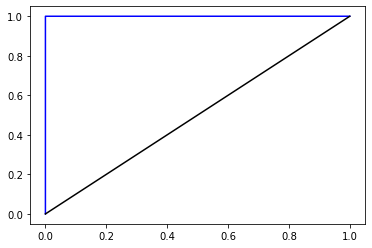

neptune.
tp=272317,fp=44,fn=1672,tn=75967
area = 0.9966593508225936


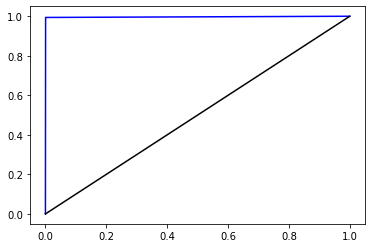

normal.
tp=276729,fp=169,fn=4421,tn=68681
area = 0.9909103432047364


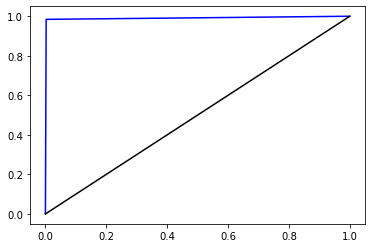

back.
tp=276991,fp=0,fn=71466,tn=1543
area = 0.8974536312945356


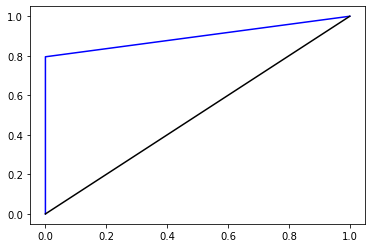

satan.
tp=319532,fp=39,fn=29333,tn=1096
area = 0.9407787658291007


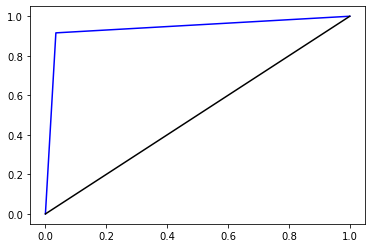

ipsweep.
tp=335716,fp=19,fn=13405,tn=860
area = 0.9699940489907566


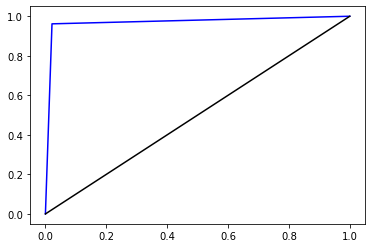

portsweep.
tp=322290,fp=13,fn=26967,tn=730
area = 0.9526454411194946


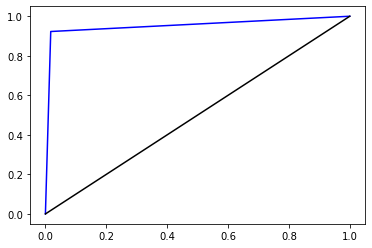

warezclient.
tp=276915,fp=0,fn=72347,tn=738
area = 0.8964287554901478


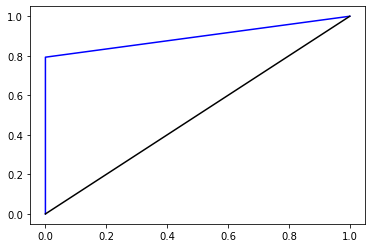

teardrop.
tp=336083,fp=0,fn=13223,tn=694
area = 0.9810724694107745


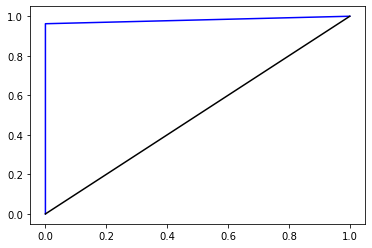

pod.
tp=347471,fp=2,fn=2336,tn=191
area = 0.9914796687813832


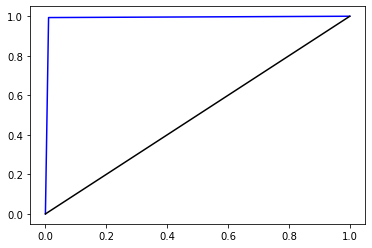

nmap.
tp=319088,fp=3,fn=30756,tn=153
area = 0.9464278803827288


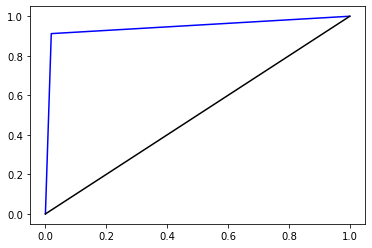

guess_passwd.
tp=336094,fp=0,fn=13872,tn=34
area = 0.9801809318619523


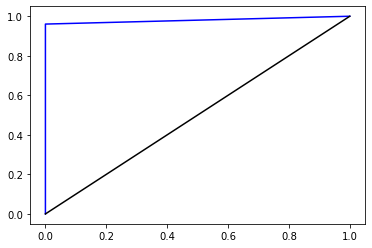

buffer_overflow.
tp=276919,fp=0,fn=73058,tn=23
area = 0.8956245696145746


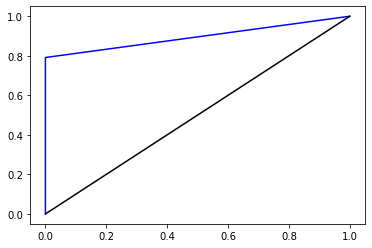

warezmaster.
tp=276879,fp=0,fn=73105,tn=16
area = 0.8955595112919448


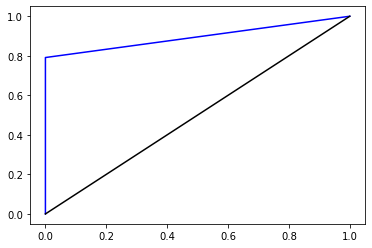

land.
tp=332150,fp=0,fn=17835,tn=15
area = 0.9745203365858537


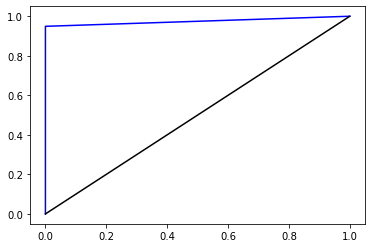

imap.
tp=276000,fp=1,fn=73994,tn=5
area = 0.8109591402519283


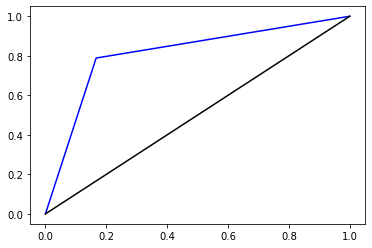

rootkit.
tp=276850,fp=0,fn=73144,tn=6
area = 0.8955067801162306


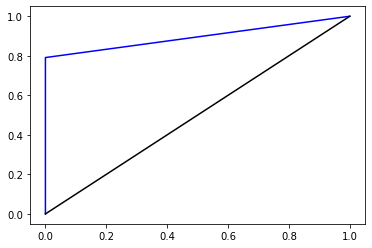

ftp_write.
tp=276929,fp=0,fn=73065,tn=6
area = 0.8956196391938147


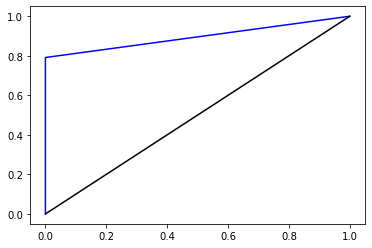

multihop.
tp=276924,fp=0,fn=73071,tn=5
area = 0.8956113658766554


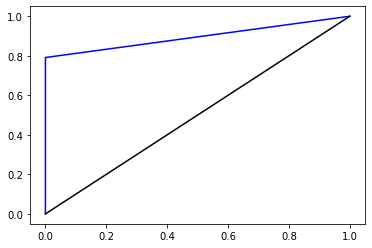

phf.
tp=276991,fp=0,fn=73005,tn=4
area = 0.8957059509251535


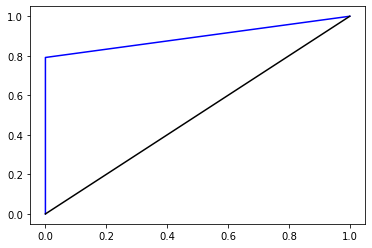

loadmodule.
tp=277002,fp=0,fn=72994,tn=4
area = 0.8957216653904616


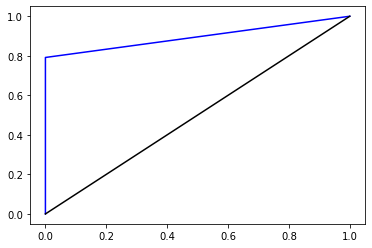

perl.
tp=276908,fp=0,fn=73090,tn=2
area = 0.8955851176292435


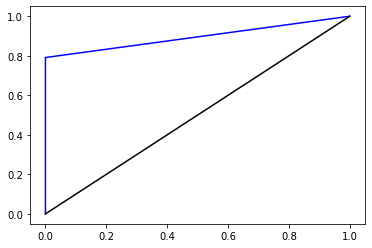

spy.
tp=276908,fp=0,fn=73090,tn=2
area = 0.8955851176292435


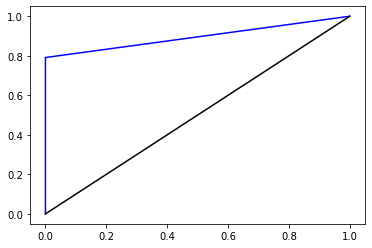

In [11]:
gru.eval()
for key in pd.Series(y_train).value_counts().index:
    print(key)
    judge(x_train, y_train, key)
